In [1]:
import pandas as pd
import numpy as np
import re
import time
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score


from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore') #удаляем варнинги навсегда, очень бесят при разработке
RS = 256 # Задаем random state

> Получим списки стоп слов

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

In [3]:
try:
    df = pd.read_csv('C:/Users/v.anufrikov/Downloads/Практикум/toxic_comments.csv', index_col=0)  # Локальный путь
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)  # Серверный путь
finally:
    print('Download complete')
    # берем чать выборки только так как выборка достаточно большая, если есть желание можешь долго ждать всю выборку
    #df = df.sample(7000).reset_index(drop=True)

In [4]:
def df_info(df):
    print(50*"+")
    df.info()
    print(50*"+")
    print('Описание переменных:')
    print(df.describe(percentiles=[.25,.5]))
    print(50*"+")
    print(f'Дубликатов в таблице = {df.duplicated().sum()}')
    print(50*"+")
    print(f'Параметры текста минимальное кол символов {df["text"].str.len().min()} максиальное {df["text"].str.len().max()}')
    print(50*"+")

df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


> Кажется мы имеем дело с английским текстом

> Исследуем df полностью, и нужно ли нам его дополнительно обрабатывать

In [5]:
df_info(df)

> Уберем поле которое дублиует индекс

In [6]:
df['text'] = df['text'].values
df['text'] = df['text'].str.lower()

> Проверим баланс классов

<AxesSubplot:>

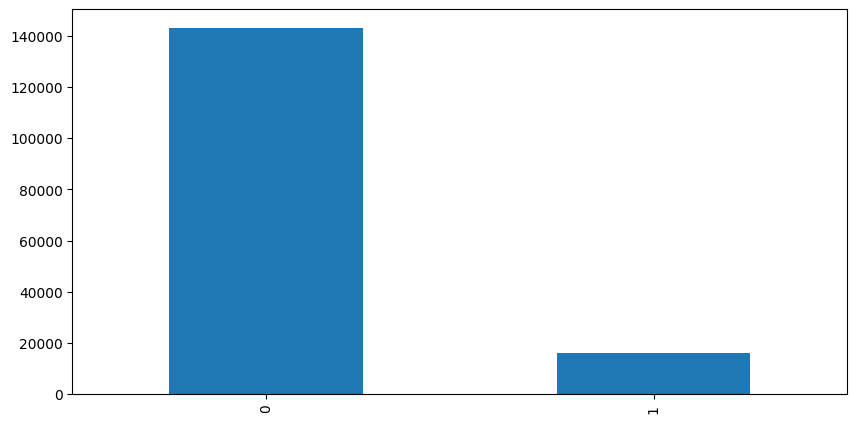

In [7]:
df['toxic'].value_counts().plot(kind='bar', figsize=(10, 5))


> Если в картце то ты можешь почитать почему это делать НЕ нужно тут
> https://habr.com/ru/post/349078/ а так же я думаю ты можешь зайти к нему в личку и спросить поподробнее


# Отчиска текста от местоимений и лишних слов через регулярки

In [8]:
english_mask = r"[^a-zA-Zа']"
def clean_text(text):
    temp = re.sub(english_mask, ' ', text)
    return " ".join(temp.split())

In [9]:
df['clean_text'] = df['text'].apply(clean_text)

In [10]:
df_info(df)

У нас появились дубликаты в таблице, около 1243 отзывов. Мы не можем точно сказать что это написал один и тот же человек поэтому закроем на это глаза

In [11]:
df[df.duplicated()].head(50)

,text,toxic,clean_text
13527,user:abd is muslim scum,1,user abd is muslim scum
29610,"""\n\n unblock request \n\n""",0,unblock request
32823,please do not vandalise wikipedia,0,please do not vandalise wikipedia
40899,you better fuck off \n\nruddy shit fuck!,1,you better fuck off ruddy shit fuck
51066,user:abd is muslim scum,1,user abd is muslim scum
53169,|class=list |importance=low,0,class list importance low
58350,"welcome!\nhello, , and welcome to wikipedia! w...",0,welcome hello and welcome to wikipedia while e...
63776,"hey \n\nhey faggot, are you dead yet? or are y...",1,hey hey faggot are you dead yet or are you wat...
64070,std\n\ncan this be considered an std?,0,std can this be considered an std
68225,"""thank you for experimenting with wikipedia. ...",0,thank you for experimenting with wikipedia you...


> Поизучал их в итоге решил удалить


In [12]:
df = df.drop_duplicates()

# Добавим немного фич

In [13]:
def unique_words(string): # Функция подсчета уникальных слов
    return len(set(str(string).split()))

In [14]:
df['words_count'] = df['text'].str.count(' ') + 1 # добавим количество слов
df['char_count'] = df['text'].str.len() # добавим длину строки
df['words_unique_count'] = df['text'].apply(unique_words) # unique строки

# Сделаем семпл нашего датасета

In [15]:
df.head()

,text,toxic,clean_text,words_count,char_count,words_unique_count
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,42,264,41
1,d'aww! he matches this background colour i'm s...,0,d'aww he matches this background colour i'm se...,18,112,17
2,"hey man, i'm really not trying to edit war. it...",0,hey man i'm really not trying to edit war it's...,42,233,39
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,112,622,81
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,13,67,13


<AxesSubplot:>

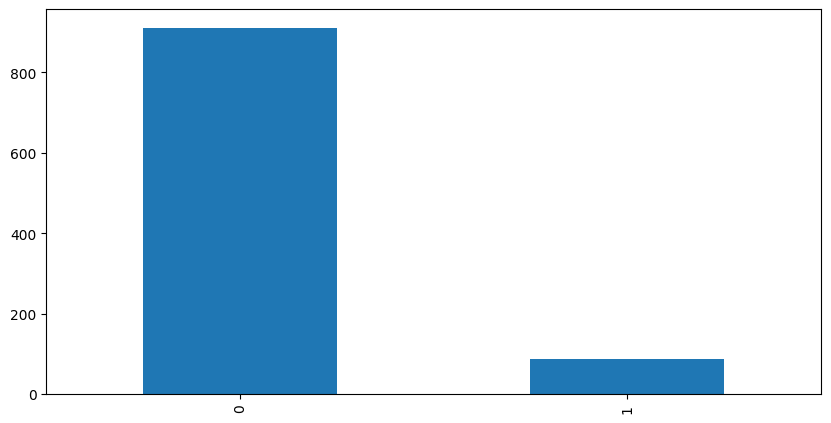

In [16]:
sample_size = 1000
corpus = df.sample(n=sample_size,random_state=RS).reset_index(drop=True)

corpus['toxic'].value_counts().plot(kind='bar', figsize=(10, 5))

# Делаем Лематизацию текста

In [17]:
from pymystem3 import Mystem
m = Mystem()

def my_counter(): #для того что бы понимать где он щас считает от общего количества строк их 5к
    my_counter.counter += 1
    print(my_counter.counter)

my_counter.counter = 0


'def lemmatize_sentence(text): # Преобразуем текст\n    lemmas = m.lemmatize(text)\n    my_counter()\n    return "".join(lemmas).strip()'

In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

True

In [19]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_sentence(text):
    
    lemmas = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    
    my_counter()
    
    return " ".join(lemmas).strip()


In [20]:
%%time

corpus['lemmatize'] = corpus['clean_text'].apply(lemmatize_sentence)

In [21]:
corpus.head()

,text,toxic,clean_text,words_count,char_count,words_unique_count,lemmatize
0,"""\n\n this guy is guilty of paying $160k for w...",0,this guy is guilty of paying k for work that r...,153,896,104,this guy be guilty of pay k for work that reas...
1,admins screw off \n\nscrew off you fucking ret...,1,admins screw off screw off you fucking retarde...,9,58,7,admins screw off screw off you fuck retard admin
2,"""\n\n slightly toned down \ni have slightly to...",0,slightly toned down i have slightly toned down...,62,373,50,slightly tone down i have slightly tone down t...
3,screw you \nstop deleting my images u fag.,1,screw you stop deleting my images u fag,9,42,8,screw you stop delete my image u fag
4,re: backlinks \n\nthe backlinks to the list ar...,0,re backlinks the backlinks to the list are nee...,65,359,52,re backlinks the backlinks to the list be need...


In [24]:
corpus.head()

,Unnamed: 0,toxic,words_count,char_count,words_unique_count,lemmatize
0,0,0,153,896,104,"""\n\n this guy is guilty of paying $160k for w..."
1,1,1,9,58,7,admins screw off \n\nscrew off you fucking ret...
2,2,0,62,373,50,"""\n\n slightly toned down \ni have slightly to..."
3,3,1,9,42,8,screw you \nstop deleting my images u fag.
4,4,0,65,359,52,re: backlinks \n\nthe backlinks to the list ar...


# Разабьем выборки

> На train_corpus будем обучать модели на test_corpus проверять их

In [26]:
train_corpus,test_corpus = train_test_split(corpus, test_size=0.2, random_state =RS, stratify = corpus['toxic'])

# TF - IDF

>выполним векторизацию слов методом TfidfVectorize


In [27]:
columns = ['words_count', 'char_count', 'words_unique_count', 'lemmatize']

Vectorizer = TfidfVectorizer(stop_words = stop_words)

# сделем fit на тренировочной выборке
fit_train = Vectorizer.fit(train_corpus['lemmatize'])

# сделем transform на тренировочной и тестовой выборке
df_train = fit_train.transform(train_corpus['lemmatize'])
df_test = fit_train.transform(test_corpus['lemmatize'])

print(f"Размер матрицы train = {df_train.shape} Размер матрицы test = {df_test.shape}")

In [28]:
features_train = df_train
target_train = train_corpus['toxic'].values

features_test = df_test
target_test = test_corpus['toxic'].values

# Добавим функию вывода результатов обучения

> Она будет получает название модели f1 и за сколько обучилась

In [29]:
result_df = pd.DataFrame(columns=['F1_predict_valid'])
result_df

,F1_predict_valid


In [30]:
def result_write(model_name,f1):
    result_df.loc[model_name,'F1_predict_valid'] = f1
    return result_df

> Сделаем оценку f1

# Попробуем векторизировать наши выборки

In [32]:
vect = CountVectorizer(ngram_range=(2, 4), stop_words=stop_words)

In [33]:
# делаем fit на обучаеющей выборке
n_gramm_train = vect.fit(train_corpus['lemmatize'])

# делаем трансформ обучающей и тестовой выборки
n_gramm_train = vect.transform(train_corpus['lemmatize'])
n_gramm_test = vect.transform(test_corpus['lemmatize'])

# проверим размерность
print(f"Размер train: {n_gramm_train.shape} Размер test: {n_gramm_test.shape}")

In [34]:
criterion = ['squared_error','absolute_error','poisson']

splitter = ['best','random']

# Number of trees used in the boosting process
n_estimators = [5, 10, 20, 30, 40, 50, 60, 70, 90, 100]

# Maximum depth of each tree
max_depth = [7, 10, 15, 20]

# Maximum depth of each tree
depth = [7, 10, 15, 20]

# Minimum number of samples per leaf
min_samples_leaf = [1 ,4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 6, 10, 16]

# Maximum number of features to consider for making splits
max_features = [ 'sqrt', 'log2', None]

boosting_type = ['gbdt', 'dart', 'goss']

iterations = [ 20, 30, 40, 50, 60]

learning_rate = np.logspace(-3, 0, 5)

num_leaves = [20, 40, 60]

class_weight = ['balanced']

C = np.linspace(0.01, 500, 5)



In [35]:
def Search(hyperparameter_grid, model, train, target):
    random_cv = RandomizedSearchCV(estimator=model,
                                   param_distributions=hyperparameter_grid,
                                   n_iter=25,
                                   scoring = 'f1',
                                   n_jobs = -1,
                                   verbose = 1,
                                   return_train_score = True,
                                   random_state=RS).fit(train,
                                                        target)

    return random_cv.best_estimator_ , random_cv.best_score_

# Настало время обучить модельки

### Logistic_Regression

In [36]:
from sklearn.linear_model import LogisticRegression

hyperparameter_grid = {
    'class_weight': class_weight,
    'C': C
}

model = LogisticRegression()

Logistic_Regression, f1_score_Logistic_Regression = Search(hyperparameter_grid,
                                                           model,
                                                           n_gramm_train,
                                                           train_corpus['toxic'])

> Гиперпараметры нашли, время замерить время обучения и обучить модель

> Запишем результаты

In [37]:
result_write(
    'CountVectorizer + Logistic_Regression',
    f1_score_Logistic_Regression
)

,F1_predict_valid
CountVectorizer + Logistic_Regression,0.179605


### DummyClassifier

In [38]:
start = time.time()
Dummy_Classifier = DummyClassifier(
    random_state=RS
).fit(
    features_train,
    target_train
)
end = time.time()
time_fit = end - start

> Запишем результаты

In [39]:
result_write(
    'TF-IDF + DummyClassifier',
    f1_score(Dummy_Classifier.predict(features_train),target_train),
)

,F1_predict_valid
CountVectorizer + Logistic_Regression,0.179605
TF-IDF + DummyClassifier,0.0


### RandomForestClassifier

In [40]:
hyperparameter_grid = {'class_weight': class_weight,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth}


model = RandomForestClassifier(random_state = RS)


Random_Forest_Classifier, f1_score_Random_Forest_Classifier = Search(hyperparameter_grid,
                                                                     model,
                                                                     features_train,
                                                                     target_train)

> Обучим модель и запишем результаты

In [ ]:
start = time.time()

Random_Forest_Classifier = RandomForestClassifier(
    **random_cv.best_params_,
    random_state = RS
).fit(
    features_train,
    target_train
)

end = time.time()

time_fit = end - start

In [41]:
result_write(
    'TF-IDF + Random_Forest_Classifier',
    f1_score_Random_Forest_Classifier,
)

,F1_predict_valid
CountVectorizer + Logistic_Regression,0.179605
TF-IDF + DummyClassifier,0.0
TF-IDF + Random_Forest_Classifier,0.485068


### CatBoostClassifier

In [42]:
Cat_Boost_Classifier = CatBoostClassifier(
    random_state = RS,
    text_features = ['lemmatize'],
    eval_metric = 'F1',
    iterations = 100,
    learning_rate = 0.2,
    auto_class_weights = 'Balanced'
)

> Обучим модель

In [43]:
start = time.time()
Cat_Boost_Classifier.fit(
    train_corpus[columns],
    train_corpus['toxic'],
    eval_set=(
        test_corpus[columns],
        test_corpus['toxic']
    ),
    plot=True
)
end = time.time()
time_fit = end - start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

> Запишем результаты

In [44]:
result_write(
    'TF-IDF+Catboost',
    f1_score(Cat_Boost_Classifier.predict(train_corpus[columns]),train_corpus['toxic'])
)

,F1_predict_valid
CountVectorizer + Logistic_Regression,0.179605
TF-IDF + DummyClassifier,0.0
TF-IDF + Random_Forest_Classifier,0.485068
TF-IDF+Catboost,0.758487


# Результаты обучения

In [45]:
result_df.head()

,F1_predict_valid
CountVectorizer + Logistic_Regression,0.179605
TF-IDF + DummyClassifier,0.0
TF-IDF + Random_Forest_Classifier,0.485068
TF-IDF+Catboost,0.758487


# Проверка лучшей модели по ROC кривой и считаем для красоты AUC-ROC

> На тренировочных данных

In [46]:
predicted_train = Cat_Boost_Classifier.predict(train_corpus[columns])
predicted_test = Cat_Boost_Classifier.predict(test_corpus[columns])

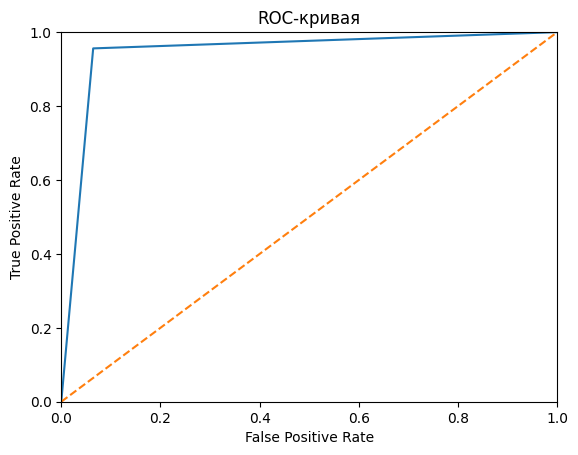

In [47]:
print("Confusion Matrix for valid data:")
print(confusion_matrix(train_corpus['toxic'], predicted_train))
print()
print("Classification Report for valid data:")
print(classification_report(train_corpus['toxic'], predicted_train))

# Смотрим отчет и ROC кривую
fpr, tpr, thresholds = roc_curve(train_corpus['toxic'], predicted_train)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print(f'AUC-ROC = {roc_auc_score(train_corpus["toxic"], Cat_Boost_Classifier.predict_proba(train_corpus[columns])[:, 1])}')

> На тестовой выборке

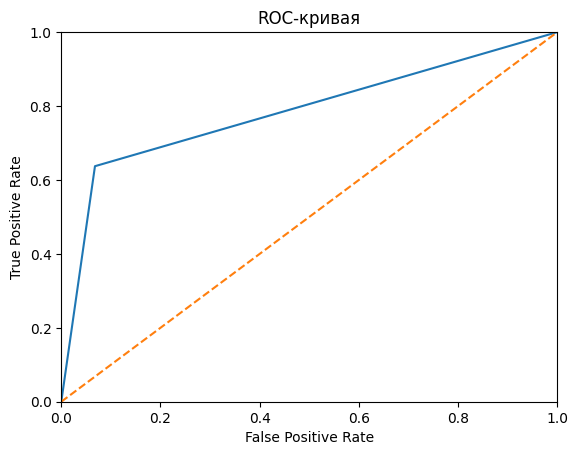

In [48]:
print("Confusion Matrix for test data:")
print(confusion_matrix(test_corpus['toxic'], predicted_test))
print()
print("Classification Report for test data:")
print(classification_report(test_corpus['toxic'], predicted_test))

# Смотрим отчет и ROC кривую
fpr, tpr, thresholds = roc_curve(test_corpus['toxic'], predicted_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print()
print(f'AUC-ROC = {roc_auc_score(test_corpus["toxic"], Cat_Boost_Classifier.predict_proba(test_corpus[columns])[:, 1])}')

# Отдельно глянем еще CountVectorizer + Logistic_Regression так как у него неплохие показетели были на трейне

In [49]:
predicted_train = Logistic_Regression.predict(n_gramm_train)
predicted_test = Logistic_Regression.predict(n_gramm_test)

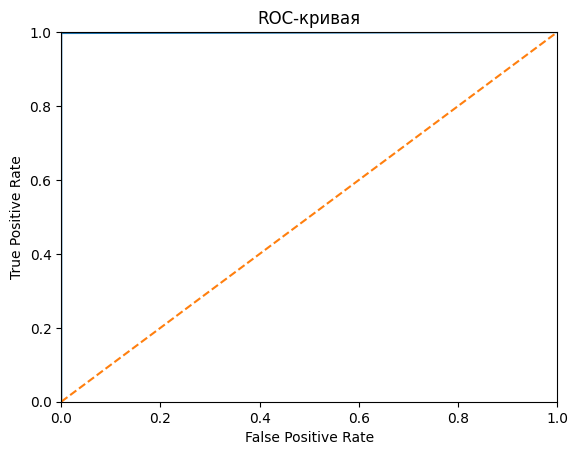

In [56]:
print("Confusion Matrix for valid data:")
print(confusion_matrix(train_corpus['toxic'], predicted_train))
print()
print("Classification Report for valid data:")
print(classification_report(train_corpus['toxic'], predicted_train))

# Смотрим отчет и ROC кривую
fpr, tpr, thresholds = roc_curve(train_corpus['toxic'], predicted_train)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print(f'AUC-ROC = {roc_auc_score(train_corpus["toxic"], Logistic_Regression.predict_proba(n_gramm_train)[:, 1])}')

> Тестовая выборка

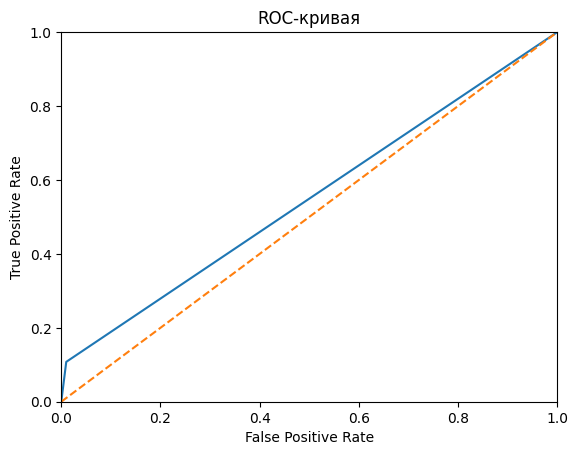

In [52]:
print("Confusion Matrix for test data:")
print(confusion_matrix(test_corpus['toxic'], predicted_test))
print()
print("Classification Report for test data:")
print(classification_report(test_corpus['toxic'], predicted_test))

# Смотрим отчет и ROC кривую
fpr, tpr, thresholds = roc_curve(test_corpus['toxic'], predicted_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print()
print(f'AUC-ROC = {roc_auc_score(test_corpus["toxic"], Logistic_Regression.predict_proba(n_gramm_test)[:, 1])}')

# Вывод

> В этой практической работе:
- Исследовали данные отзывов
- Отчистили данные от лишних символов не похожих на англиский язык
- Лемантирировали слова к изначальной форме что было очень долго 1к стро = 1 час работы ПК
- Выполнили верторизацию слов через метод  TfidfVectorize и CountVectorizer
- Подобрали гиперпараметры к моделям (DecisionTreeClassifier не захотел работать подскажи плиз что с ним не так)
- Обучили CountVectorizer + Logistic_Regression, TF-IDF + DummyClassifier, TF-IDF+Random_Forest_Classifier и Catboost
- Проверили лучшую модель и построили графики ROC кривой, в нашем случае это оказалась Catboost с оценкой 0.57 на тестовой выборке и  AUC-ROC = 0.874